# Reduced Wong-Wang model - Numba

In [1]:
import os
import vbi
import warnings
import numpy as np
import pandas as pd
from cmaes import CMA
import networkx as nx
from tqdm import tqdm
from copy import deepcopy
from vbi.utils import timer
import multiprocessing as mp
import matplotlib.pyplot as plt
from multiprocessing import Pool
from vbi.models.numba.rww import RWW_sde
from vbi.feature_extraction.features_utils import get_fcd
from vbi import (
    extract_features,
    get_features_by_domain,
    get_features_by_given_names,
    update_cfg,
)

warnings.simplefilter("ignore")

In [2]:
seed = 42
np.random.seed(seed)

LABESSIZE = 10
plt.rcParams["axes.labelsize"] = LABESSIZE
plt.rcParams["xtick.labelsize"] = LABESSIZE
plt.rcParams["ytick.labelsize"] = LABESSIZE

In [3]:
path = "output/r_ww_sde_numba_"
os.makedirs(path, exist_ok=True)

In [4]:
def wrapper(par, p=None, cfg=None, extract_feature=False):
    """Wrapper function to run the WW_sde model with given parameters."""
    par = deepcopy(par)
    sde = RWW_sde(par)

    if p is not None:
        p = dict(
            G=p,
            # I_ext=p[1],
        )
    else:
        p = {}

    data = sde.run(p)
    S_t = data["t"]
    S_d = data["S"]
    bold_d = data["bold_d"]
    bold_t = data["bold_t"]

    if extract_feature:
        stat = extract_features(
            [bold_d.T],
            1 / par["dt"] / par["tr"],
            cfg,
            n_workers=1,
            verbose=False,
        )
        values = stat.values
        labels = stat.labels

        return values, labels

    if par["RECORD_S"]:
        return S_t, S_d, bold_t, bold_d
    else:
        return bold_t, bold_d


def batch_run(par, p, cfg, n_workers=1):

    n = len(p)

    def update_bar(_):
        pbar.update()

    with Pool(processes=n_workers) as pool:
        with tqdm(total=n) as pbar:
            async_results = [
                pool.apply_async(
                    wrapper, args=(par, p[i], cfg, True), callback=update_bar
                )
                for i in range(n)
            ]
            stat_vec = [res.get()[0] for res in async_results]
    return stat_vec

In [5]:
# --- define feature extraction configuration ---

cfg = get_features_by_domain("connectivity")
cfg = get_features_by_given_names(cfg, ["fcd_stat"])
cfg = update_cfg(cfg, "fcd_stat", parameters={"k": None, "win_len": 30, "TR": 0.5})
# report_cfg(cfg)

In [6]:
D = vbi.LoadSample(nn=84)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

number of nodes: 84


In [11]:
# --- Simulation Parameters ---
theta_true = [1.2]#, 0.05]  # G_exc, ext_current
par = dict(
    weights=weights,
    nn=nn,
    dt=2.5,  # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000,  # ms
    G=theta_true[0],
    sigma=0.05,
    I_ext=0.05,
    RECORD_S=True,
    s_decimate=10,
    tr=300.0,  # ms
    seed=42,
    # initial_state=np.random.uniform(0, 0.2, nn)
)

S_t, S_d, bold_t, bold_d = wrapper(par)
df_obs = extract_features(
    [bold_d.T],
    1 / par["dt"] / par["tr"],
    cfg,
    n_workers=1,
    output_type="dataframe",
    verbose=False,
)
try:
    print(df_obs[["fcd_full_ut_std"]].values[0])
except:
    pass

[0.11697971]


In [8]:
df_obs.to_csv(path+"/df_obs.csv", index=False)
np.savez(path+"/data_obs.npz", S_t=S_t, S_d=S_d, bold_t=bold_t, bold_d=bold_d, theta=theta_true)

In [9]:
print(S_t.shape, S_d.shape, bold_t.shape, bold_d.shape)

(9599,) (9599, 84) (799,) (799, 84)


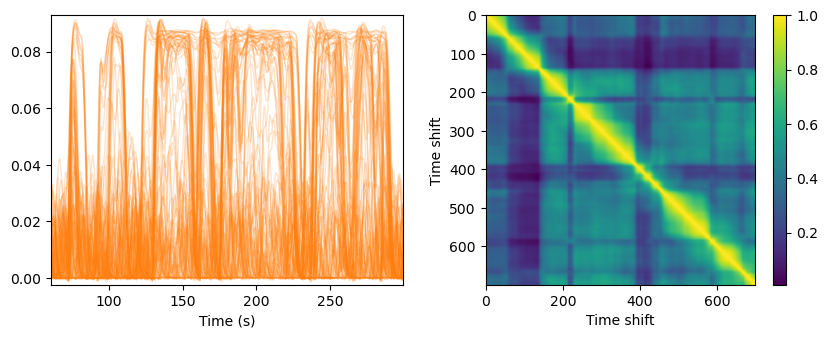

In [12]:
fcd = get_fcd(bold_d.T, win_len=30, TR=0.3)['full']

plt.figure(figsize=(10, 3.5))
ax1 = plt.subplot(121)
ax1.plot(bold_t/1000, bold_d, lw=1, alpha=0.2, color="C1")
ax1.set_xlabel('Time (s)')
ax1.margins(x=0, y=0.01)
ax2 = plt.subplot(122)
im = ax2.imshow(fcd, cmap="viridis", aspect="equal")
plt.colorbar(im, ax=ax2)
plt.xlabel('Time shift')
plt.ylabel('Time shift')
plt.show()

In [12]:
ww = RWW_sde(par)
print(ww)

To estimate `G`:
1. Set appropriate prior intervals.  
2. Generate simulated training data.  
3. Extract relevant features.  
4. Train neural network to build posterior.  
5. Sample from posterior distribution.  
6. Visualize posterior distributions.

In [11]:
from vbi.utils import BoxUniform
from vbi.sbi_inference import Inference
import torch 
import sbi.utils as utils
num_sim = 200
gmin, gmax = 0., 2.5
prior_min = [gmin]
prior_max = [gmax]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

obj = Inference()
theta = obj.sample_prior(prior, num_sim, seed=seed)
theta_np = theta.numpy().squeeze().astype(np.float64)
torch.save(theta, path+ "/theta.pt")
torch.save(prior, path+ "/prior.pt")

In [12]:
par = dict(
    weights=weights,
    nn=nn,
    dt=2.5,  # ms
    t_end=5 * 60 * 1000.0,  # ms
    t_cut=1 * 60 * 1000,  # ms
    G=0.0,
    sigma=0.05,
    I_ext=0.05,
    RECORD_S=False,
    s_decimate=10,
    tr=300.0,  # ms
    seed=42,
)

In [13]:
X = batch_run(par, theta_np, cfg, n_workers=10)

100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


In [14]:
X_df = pd.DataFrame(np.array(X).squeeze(), columns=df_obs.columns)
X_df.to_pickle(path+"dataframe_X.pkl")
remained_columns = X_df.std() > 1e-5
X_df = X_df.loc[:, remained_columns]
x = X_df.values 
x = torch.tensor(x, dtype=torch.float32)
torch.save(x, path+ "/features.pt")
remained_columns.to_csv(path+"remained_columns.csv", index=False)

In [15]:
x.shape, theta.shape, type(remained_columns)

(torch.Size([200, 22]), torch.Size([200, 1]), pandas.core.series.Series)

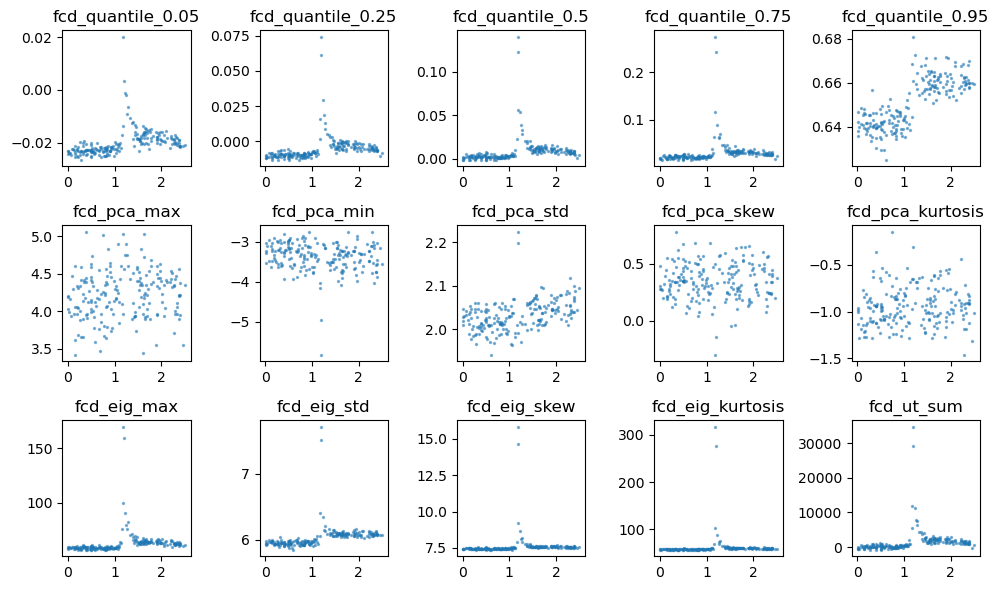

In [16]:
# plot scatter plot of the features
df_obs = pd.read_csv(path+"/df_obs.csv")
column_labels = df_obs.columns
column_labels = column_labels[remained_columns]
fig, ax = plt.subplots(3,5, figsize=(10,6))
for i in range(3):
    for j in range(5):
        ax[i,j].scatter(theta_np, x[:, i*5+j], s=2, alpha=0.5)
        label = column_labels[i*5+j]
        label = label.replace("full_", "")
        ax[i,j].set_title(label)

plt.tight_layout()

In [17]:
obj = Inference()
posterior = obj.train(theta, x[:,0], prior, num_threads=4)

 Neural network successfully converged after 165 epochs.train Done in 0 hours 0 minutes 04.829362 seconds


In [18]:
df_obs = pd.read_csv(path+"/df_obs.csv")
df_obs = df_obs.loc[:, remained_columns]
x_obs = torch.tensor(df_obs.values.squeeze(), dtype=torch.float32)

In [19]:
samples = obj.sample_posterior(x_obs[0], 10000, posterior)
torch.save(samples, path+"/samples.pt")

  0%|          | 0/10000 [00:00<?, ?it/s]

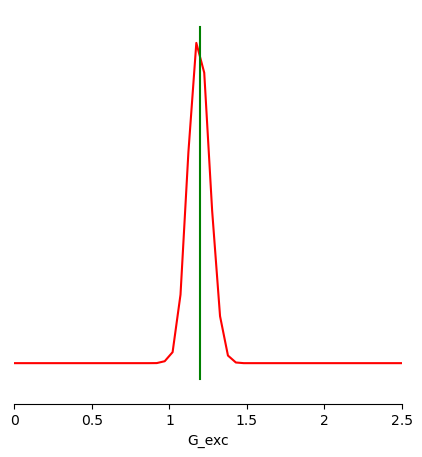

In [20]:
from sbi.analysis import pairplot

limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=[theta_true],
    labels=["G_exc"],
    offdiag='kde',
    diag='kde',
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)